In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import siamxt
import matplotlib.patches as patches
import pandas as pd

In [2]:
pcb = cv2.imread('rec1-1.jpg')
pcb = cv2.cvtColor(pcb,cv2.COLOR_BGR2RGB)

### Displaying the image

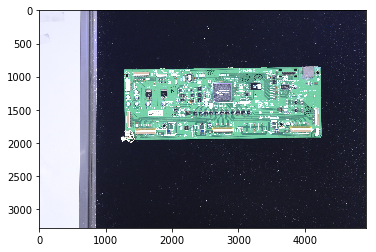

In [3]:
plt.imshow(pcb)

### Crop Function

At this first step, we create a function to crop the image and detect only the pcb, avoiding get possible shapes outside the pcb

In [4]:
def crop_pcb(pcb):
    board = pcb[:,:,1].astype(np.int)-pcb[:,:,0]
    board[board<0]=0
    board=board.astype(np.uint8)
    ret,th1 = cv2.threshold(board,board.mean(),255,cv2.THRESH_BINARY)

    area = 50
    Bc = np.ones((3,3),dtype = bool)
    Bc[0,0]=False
    Bc[2,0]=False
    Bc[0,2]=False
    Bc[2,2]=False


    mxt = siamxt.MaxTreeAlpha(th1,Bc)
    mxt.areaOpen(area)

    max_excluding_fist = max(mxt.node_array[3,1:])

    max_idx = 0
    for idx,val in enumerate(mxt.node_array[3][1:]):
        if val == max_excluding_fist:
            max_idx=idx+1
            break

    ymin = mxt.node_array[6,max_idx]
    ymax = mxt.node_array[7,max_idx]
    xmin = mxt.node_array[9,max_idx]
    xmax = mxt.node_array[10,max_idx]

    return pcb[ymin:ymax,xmin:xmax,:]    

In [5]:
pcb_cropped = crop_pcb(pcb)

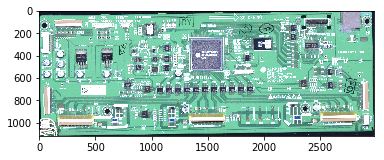

In [6]:
plt.imshow(pcb_cropped)

Finding image shapes:

In [81]:
pcb_cropped.shape

(1116, 2986, 3)

As we can see, the function works properly. The next step refers to shape localization in pcbs. We will now define 4 functions to do so.

### Shape Location

As said before, this step is divided into four functions:
- *max_tree_filtering*: Aplies max-tree filtering on a given image and returns connected components (CCs) based on the filter parameters
- *extract_boundig_boxes*: Find the bbox of CCs found on previous step and apply non-maximum supression
- *non_max_suppression*: Runs non-maximum supression
- *shapes_in_pcb*: Get a pcb image and return all bbox found for different shapes



In [24]:
def max_tree_filtering(im):
    h,w = im.shape
    
    #Structuring element with connectivity-4
    Bc = np.ones((3,3),dtype = bool)
    Bc[0,0]=False
    Bc[2,0]=False
    Bc[0,2]=False
    Bc[2,2]=False
    #retangularity coeficient. Used to get only components. helps removing noise
    rr = 0.25

    mxt = siamxt.MaxTreeAlpha(im,Bc)
    
    g_min = im.mean()
    area_min = h*w//20000
    g_l = mxt.node_array[2,:]
    area = mxt.node_array[3,:]

    RR = mxt.computeRR()
    #set filters of grayscale value, rectangularity and area
    nodes = (g_l>g_min) & (area>area_min) & (RR>rr)#& (area<area_max)

    mxt.contractDR(nodes)

    img_filtered =  mxt.getImage()    
    return mxt.node_array[:,1:]

In [25]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    pick = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        overlap = (w * h) / area[idxs[:last]]
 
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

In [41]:
def extract_bounding_boxes(all_nodes, plot=False):
    xmin = all_nodes[6,:]
    xmax = all_nodes[7,:]
    ymin = all_nodes[9,:]
    ymax = all_nodes[10,:]
    
    b_list = []
    for x1, y1, x2, y2 in zip(xmin,ymin,xmax,ymax):
        b_list.append([x1,y1,x2,y2])    
    b_array = np.asarray(b_list)
    out = non_max_suppression(b_array, overlapThresh=0.1)
    
    if plot:
        fig, ax = plt.subplots(1,figsize=(30,30))

        ax.imshow(pcb_cropped, cmap="gray")
        
        for idx, box in enumerate(out):
            w=box[2]-box[0]
            h=box[3]-box[1]
            rect = patches.Rectangle((box[1],box[0]),h,w,linewidth=2,edgecolor='r',facecolor='none')
            ax.text(box[1],box[0],str(idx),fontsize=20, color="r")
            ax.add_patch(rect)
        plt.show()
        
    return out

In [42]:
def shapes_in_pcb(pcb, plot=False):
    #Try to locate the background
    board = pcb[:,:,1].astype(np.int)-pcb[:,:,0]    
    board[board<0]=0
    board=board.astype(np.uint8)
    ret,th1 = cv2.threshold(board,board.mean(),255,cv2.THRESH_BINARY)

    #set the background to black
    pcb_g = cv2.cvtColor(pcb_cropped, cv2.COLOR_RGB2GRAY)
    pcb_data = pcb_g & 255-th1
    
    #set the white messages to background also they give a lot of false positives if this step is not set
    pcb_data[pcb_data>pcb_data.max()*0.9]=0
    
    #another threshold to get some dark components a high value.
    ret,th1_pcb = cv2.threshold(pcb_data,pcb_data.mean(),255,cv2.THRESH_BINARY)
    im=th1_pcb
    #max tree filtering. Return all nodes of max-tree except the background one
    all_nodes = max_tree_filtering(im)
    #filter bounding boxes. Get x1, x2, y1, y2 and run NMS
    boxes = extract_bounding_boxes(all_nodes, plot)
    
    return boxes

### Plotting the image and bboxes

Lets run shapes_in_pcb to get shapes in pcb. For display, we are going to set plot=True.

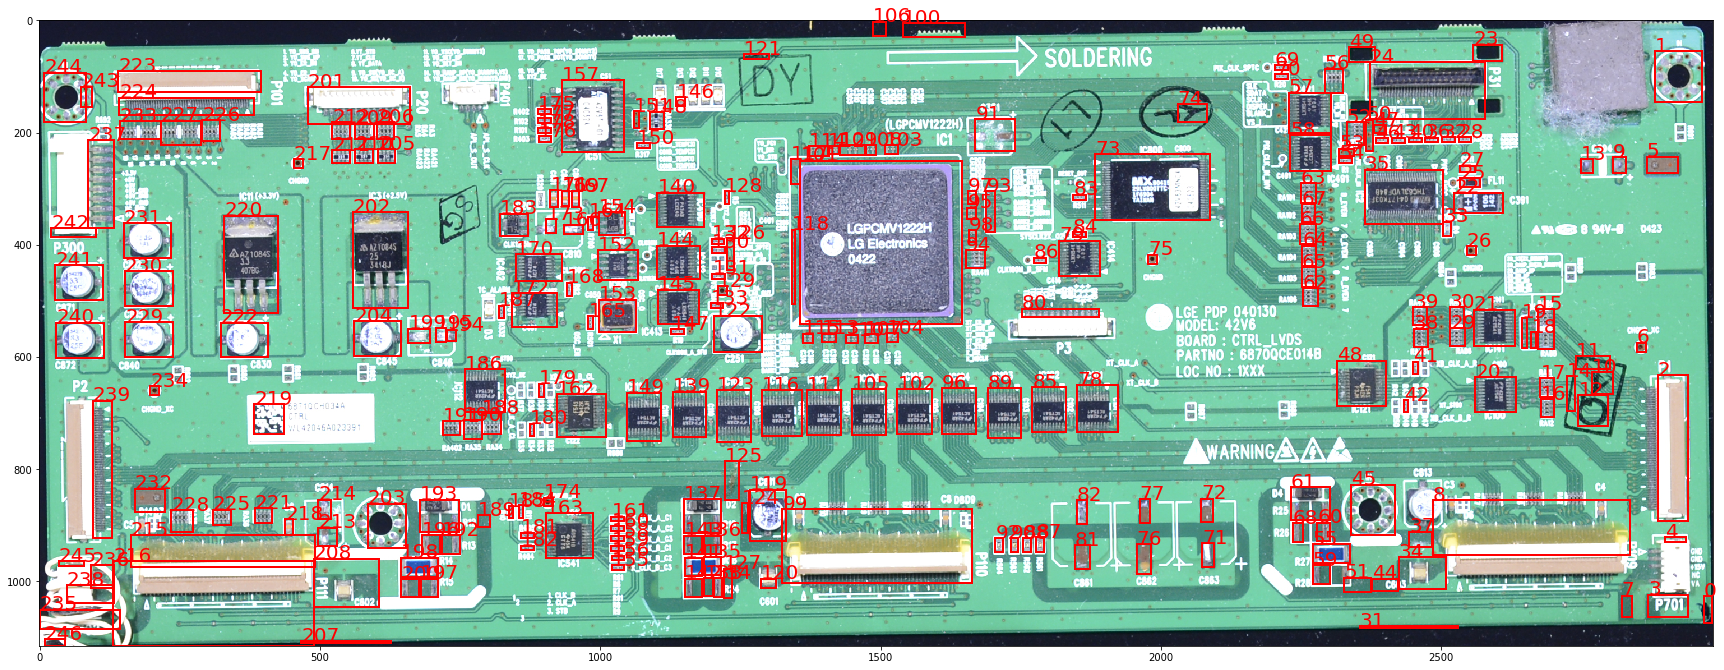

In [43]:
bboxes = shapes_in_pcb(pcb_cropped, plot=True)

Now, lets save the cropped image and the corresponding bounding boxes:

### Saving bbox info into .csv file

Finally, all bbox index and coordinates are saved into a .csv file labeled *compShare.csv*

In [84]:
def save_bbox_coord(bbox_list):
    bboxes = np.asarray(bbox_list)
    pd_val = pd.DataFrame(bboxes, columns=['X1','Y1','X2','Y2'])
    pd_val.index.name="idx"
    pd_val.to_csv("compShape.csv")

In [85]:
save_bbox_coord(bboxes)

I'm now going to save the cropped pcb to be reused

In [86]:
cv2.imwrite("cropped_pcb.jpg",pcb_cropped)

True